# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Сначала обновим и установим библиотеки для использования всяких новых фишек :)

In [1]:
#!pip update scikit-learn==0.24.2 --quiet
!pip install notifiers --quiet
!pip install scikit-learn --upgrade --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import warnings
warnings.simplefilter('ignore')
import time
import matplotlib.pyplot as plt
import numpy as np

####### SKLEARN ####### 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

#preprocessing
from sklearn.preprocessing import OrdinalEncoder

#metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier, Pool

import lightgbm as lgb

from notifiers import get_notifier 

rand_state = 54321
encoding_ohe = 'OHE'
encoding_ordinal = 'Ordinal'


## Подготовка данных

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<b>Итого:</b>
- много пропусков. Столбцы: VehicleType, Gearbox, Model, FuelType, NotRepaired нужно обработать
- в столбцах Price, Power, RegistrationYear есть аномалии. Их нужно обработать

### Удаление ненужных столбцов

Дропаем объективно ненужные столбцы. Для моделей эти данные не нужны

In [7]:
data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], inplace=True)

In [8]:
data.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
254,10800,small,2010,manual,105,a1,125000,gasoline,audi,no,0
95738,14990,bus,2009,manual,140,galaxy,70000,gasoline,ford,no,0
217231,7430,sedan,2004,manual,116,1er,125000,petrol,bmw,no,0
196194,4250,sedan,2006,manual,105,3_reihe,125000,petrol,mazda,no,0
324894,0,wagon,1997,manual,0,mondeo,150000,petrol,ford,no,0


In [9]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
NumberOfPictures        0
dtype: int64

### Обработка RegistrationYear

Будем замерять количество записей ДО и после каждой обработки

In [10]:
data.shape

(354369, 11)

По быстрому прикинем распределения

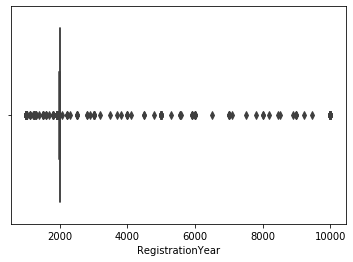

In [11]:
sns.boxplot(data['RegistrationYear']);

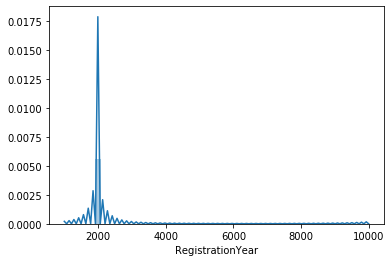

In [12]:
sns.distplot(data['RegistrationYear'])

Видно, что данные в основном вокруг 2000 года, в обе стороны имеется много выбросов. Посмотрим, много ли записей потеряем, если обрежем период 1950-2016 года

In [13]:
data[(data['RegistrationYear']<1950) | (data['RegistrationYear']>2016)].shape

(14776, 11)

Данных не много, дропнем, остальное будем считать аномалией

In [14]:
data = data[(data['RegistrationYear']>1950) & (data['RegistrationYear']<=2016)]
data.shape

(339575, 11)

### Обработка Power

По быстрому прикинем распределения

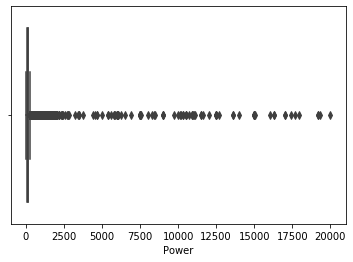

In [15]:
sns.boxplot(data['Power']);

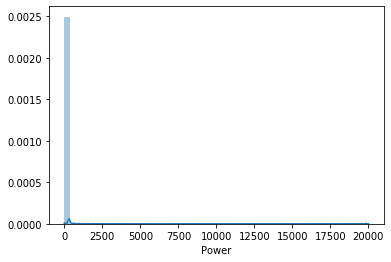

In [16]:
sns.distplot(data['Power']);

Посмотрим что, например, выше 500 лошадей

In [17]:
data[data['Power'] > 500].sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
252980,2885,convertible,2009,manual,702,500,50000,petrol,fiat,yes,0
184141,17000,sedan,2004,auto,620,e_klasse,150000,petrol,mercedes_benz,NaN,0
54753,5500,small,2007,NaN,805,corsa,40000,petrol,opel,NaN,0
177451,11999,wagon,2002,auto,505,other,150000,petrol,audi,no,0
100680,3500,sedan,1993,auto,11635,80,125000,petrol,audi,no,0
192034,3500,wagon,2003,manual,1317,NaN,150000,gasoline,volkswagen,no,0
260366,950,small,2001,manual,999,other,125000,petrol,hyundai,no,0
145154,1200,sedan,2000,manual,1503,NaN,150000,petrol,bmw,NaN,0
241096,2500,coupe,2005,auto,507,m_reihe,125000,petrol,bmw,yes,0
249332,2600,sedan,2001,auto,1595,golf,5000,petrol,volkswagen,no,0


Совершенно случайные автомобили, если до 500 лошадей автомобили выглядят еще более правдоподобно, то выше, скорее всего аномалии. Дропне все, что больше. Вполне возможно, что 0 это нерабочие авто не запчасти, их удалять не будем.

In [18]:
data=data[data['Power'] <= 500]
data.shape

(339157, 11)

### Обработка Price

По быстрому прикинем распределения

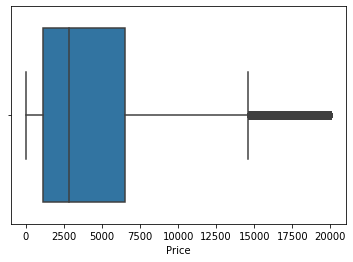

In [19]:
sns.boxplot(data['Price']);

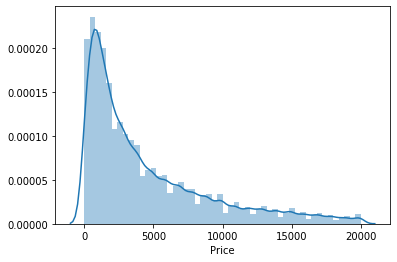

In [20]:
sns.distplot(data['Price'])

In [21]:
data['Price'].describe()

count    339157.000000
mean       4471.311378
std        4543.719184
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [22]:
data[data['Price']>15000]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,0
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no,0
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no,0
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no,0
179,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no,0
...,...,...,...,...,...,...,...,...,...,...,...
354210,17990,bus,2007,auto,174,transporter,125000,gasoline,volkswagen,no,0
354279,16500,suv,2013,manual,116,i_reihe,30000,gasoline,hyundai,no,0
354286,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes,0
354306,16999,wagon,2008,auto,269,a6,150000,gasoline,audi,no,0


In [23]:
data[data['Price']<2]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,0
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN,0
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN,0
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,0
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes,0
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN,0
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN,0
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,0


Вполне возможно, что это особенности доски объявлений, когда машины продают на запчасти или что-то похожее, т.к. машины в основном старые и с большим пробегом.
Ничего не будем делать с ценой, тем более что это целевой признак.

### Обработка пропусков

#### Пропуски в Model

In [24]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
       'up', 'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
       

In [25]:
data[data['Model'].isna()].sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
263341,500,small,1998,manual,75,NaN,150000,petrol,ford,yes,0
47592,400,coupe,1995,manual,130,NaN,150000,NaN,mazda,NaN,0
264805,2300,wagon,2004,auto,177,NaN,150000,NaN,opel,NaN,0
259476,2000,NaN,2000,NaN,0,NaN,125000,NaN,bmw,NaN,0
65676,6100,bus,2005,manual,0,NaN,150000,NaN,sonstige_autos,NaN,0
239038,1100,NaN,2005,NaN,0,NaN,150000,NaN,renault,NaN,0
88741,0,NaN,2005,NaN,0,NaN,150000,NaN,opel,NaN,0
161606,2550,NaN,1985,manual,0,NaN,125000,NaN,volkswagen,NaN,0
119169,14500,wagon,2011,auto,311,NaN,150000,petrol,sonstige_autos,no,0
345283,2500,sedan,2003,manual,125,NaN,150000,gasoline,opel,no,0


In [26]:
data['Model'].isna().sum()

17482

По данным непонятно, чем заполнять модель автомобиля. Так как закономерности не видно. Тем более это помешает заполнить следующие пропуски. Так как записей не очень много, то просто дропнем их

In [27]:
data.dropna( how='all', subset=['Model'], inplace=True)
data.shape

(321675, 11)

### Пропуски в VehicleType

In [28]:
data['VehicleType'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

In [29]:
data['VehicleType'].isna().sum()

18109

In [30]:
data[data['VehicleType'].isnull()].sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
108447,7500,NaN,2010,manual,130,megane,100000,NaN,renault,no,0
14605,1599,NaN,2016,manual,0,a_klasse,150000,gasoline,mercedes_benz,NaN,0
293021,250,NaN,1995,auto,90,golf,125000,petrol,volkswagen,yes,0
292713,8500,NaN,2007,manual,170,golf,150000,NaN,volkswagen,no,0
128807,520,NaN,2016,manual,0,twingo,150000,petrol,renault,NaN,0


Логично предположить, что одинаковые модели одинаковых брендов это примерно один и тот же тип кузова. Попробуем заполнить по вышеуказанной группировке

In [31]:
data['VehicleType'] = data['VehicleType'].fillna(data.groupby(['Brand','Model'])['VehicleType']
                                        .transform(lambda x: x.value_counts().idxmax()))

In [32]:
data['VehicleType'].isna().sum()

0

### Пропуски в Gearbox

In [33]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [34]:
data['Gearbox'].isna().sum()

14176

Тут аналогичная ситуация - одинаковые модели одинаковых брендов это примерно один и тот же тип коробки передач. Попробуем заполнить по вышеуказанной группировке

In [35]:
data['Gearbox'] = data['Gearbox'].fillna(data.groupby(['Brand','Model'])['Gearbox']
                                        .transform(lambda x: x.value_counts().idxmax()))

In [36]:
data['Gearbox'].isna().sum()

0

### Пропуски в FuelType

In [37]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Очевидно, что 'petrol' и 'gasoline' это одно и то же. Заменяем

In [38]:
data.loc[data['FuelType']=='gasoline', 'FuelType'] = 'petrol'

In [39]:
data['FuelType'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [40]:
data['FuelType'].isna().sum()

21092

Тут аналогичная ситуация - одинаковые модели одинаковых брендов это примерно один и тот же тип топлива. Попробуем заполнить по вышеуказанной группировке

In [41]:
data['FuelType'] = data['FuelType'].fillna(data.groupby(['Brand','Model'])['FuelType']
                                        .transform(lambda x: x.value_counts().idxmax()))

In [42]:
data['FuelType'].isna().sum()

0

### Пропуски в NotRepaired

In [43]:
data['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

Признака, по которому можно было бы восстановить пропуски в датасете нет, однако же и пропусков довольно много. ПРосто напишем, что пустые значения нам неизвестны, т.е. 'unknown'

In [44]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

In [45]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
NumberOfPictures    0
dtype: int64

<b>Итого:</b> пропуски заполнили/дропнули, с аномалиями разобрались, можно фитить модельки!

## Обучение моделей

In [46]:
#база моделей и диапазона подбираемых гиперпараметров
data_models = [['Линейная регрессия','sklearn.linear_model','LinearRegression', 
                {}],
    
               ['LightGBM','lightgbm','LGBMRegressor', 
                {'regressor__learning_rate': [0.4, 0.5],
                 'regressor__max_depth': [10, 20, 50, 60, 70, 80, 90]}],
               
               ['Случайный лес','sklearn.ensemble','RandomForestRegressor',
                 {'regressor__n_estimators': [20, 40, 60, 80, 100],
                  'regressor__max_depth':  [10, 20, 30, 40]}],
               
               ['CatBoost','catboost','CatBoostRegressor',
                  {'regressor__depth'         : [6, 8, 10],
                   'regressor__learning_rate' : [0.01, 0.05, 0.1],
                   'regressor__iterations'    : [30, 50, 100]
                 }]
               ]    
models_df = pd.DataFrame(data_models, columns = ['label','module','model', 
                                                 'parameters'])
models_df

,label,module,model,parameters
0,Линейная регрессия,sklearn.linear_model,LinearRegression,{}
1,LightGBM,lightgbm,LGBMRegressor,"{'regressor__learning_rate': [0.4, 0.5], 'regr..."
2,Случайный лес,sklearn.ensemble,RandomForestRegressor,"{'regressor__n_estimators': [20, 40, 60, 80, 1..."
3,CatBoost,catboost,CatBoostRegressor,"{'regressor__depth': [6, 8, 10], 'regressor__l..."


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321675 entries, 0 to 354368
Data columns (total 11 columns):
Price               321675 non-null int64
VehicleType         321675 non-null object
RegistrationYear    321675 non-null int64
Gearbox             321675 non-null object
Power               321675 non-null int64
Model               321675 non-null object
Kilometer           321675 non-null int64
FuelType            321675 non-null object
Brand               321675 non-null object
NotRepaired         321675 non-null object
NumberOfPictures    321675 non-null int64
dtypes: int64(5), object(6)
memory usage: 29.5+ MB


In [48]:
data.sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
11133,2800,sedan,2000,manual,184,3er,150000,petrol,bmw,yes,0
324363,0,sedan,1996,manual,0,megane,150000,petrol,renault,unknown,0
282148,4100,sedan,2006,manual,116,a_klasse,150000,lpg,mercedes_benz,no,0
319613,1250,small,2001,manual,75,corsa,150000,petrol,opel,no,0
96802,5900,sedan,2006,manual,122,1er,150000,petrol,bmw,no,0
115939,11750,sedan,2012,manual,105,golf,150000,petrol,volkswagen,no,0
56042,5300,sedan,2009,manual,80,golf,150000,petrol,volkswagen,no,0
215765,250,small,2000,manual,0,corsa,150000,petrol,opel,yes,0
241451,9600,convertible,2008,manual,140,astra,80000,petrol,opel,yes,0
270389,1500,small,2004,manual,0,corsa,150000,petrol,opel,no,0


In [1]:
categorical_features = data.select_dtypes(include='object').columns
numeric_features = data.drop(['Price'], axis=1).select_dtypes(include='int64').columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])
#categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])


def split_data(df, target_column, rand_state):
    features = df.drop([target_column], axis=1)
    target = df[target_column]
    features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rand_state)
    return features_train, target_train, features_test, target_test

def make_notifier(token='1801355779:AAH0ETlq5i2FIX9urLGpmkdbbxV0eKsYfPE',
                 chat_id=-557183441):
    def send(text):
        telegram=get_notifier('telegram')
        telegram.notify(message=text,
                       token=token,
                       chat_id=chat_id)
    return send

send = make_notifier()

#функция выбора модели

#sampling:
#'balanced' - включаем параметр балансировки классов
def choose_model(df, target_col, sampling, encoding):
    features_train, target_train, features_test, target_test = split_data(df, 
                                                                          target_col, 
                                                                          rand_state)
    data_result = []
    for index, row in models_df.iterrows():
        #загружаем класс модели
        ModelClass = getattr(importlib.import_module(row['module']), row['model'])
        model = ModelClass()
        model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', model)])
        
        #подбираем параметры гридсерчем по метрике RMSE, задав свой скорер
        send('Gridsearch модели: ' + row['label'] + '...')
        print('Gridsearch модели:', row['label'], '...')
        start_time = time.time()
        grid = GridSearchCV(model_pipeline, row['parameters'], cv=4, 
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            verbose=3)
        grid.fit(features_train, target_train)
        grid_time = (time.time() - start_time)/grid.n_splits_

        #вычисляем RMSE на тестовых данных
        print('Тест модели: ', row['label'], '...')
        start_time = time.time()
        predicted_test = grid.best_estimator_.predict(features_test)
        rmse = mean_squared_error(target_test, predicted_test, squared=False)
        predict_time = time.time() - start_time
        
        data_result.append([rmse,  sampling, encoding, grid_time, predict_time, 
                            row['label'], row['module'], row['model'], 
                            grid.best_params_])
        
    data_result = pd.DataFrame(data_result, columns = ['RMSE','sampling',
                                                       'encoding','grid time(mean fold time)', 
                                                       'predict time','label', 
                                                       'module','model', 
                                                       'optimal_parameters'])
    return data_result

NameError: name 'data' is not defined

## Анализ моделей

In [52]:
send('--->>> Начало анализа моделей...')
models_result = choose_model(data, 'Price', 'none', encoding_ordinal)
send('Анализ закончен!')

Gridsearch модели: Линейная регрессия ...
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END ..............................., score=-3128.932 total time=   0.8s
[CV 2/4] END ....................................., score=nan total time=   0.9s
[CV 3/4] END ..............................., score=-3170.465 total time=   0.9s
[CV 4/4] END ..............................., score=-3154.776 total time=   1.0s
Тест модели:  Линейная регрессия ...
Gridsearch модели: LightGBM ...
Fitting 4 folds for each of 14 candidates, totalling 56 fits
[CV 1/4] END regressor__learning_rate=0.4, regressor__max_depth=10;, score=-1727.262 total time=  24.3s
[CV 2/4] END regressor__learning_rate=0.4, regressor__max_depth=10;, score=nan total time=  16.6s
[CV 3/4] END regressor__learning_rate=0.4, regressor__max_depth=10;, score=-1736.431 total time=  29.3s
[CV 4/4] END regressor__learning_rate=0.4, regressor__max_depth=10;, score=-1735.760 total time=  19.5s
[CV 1/4] END regressor__learning_ra

In [53]:
models_result

,RMSE,sampling,encoding,grid time(mean fold time),predict time,label,module,model,optimal_parameters
0,3155.649551,none,Ordinal,1.165657,0.283916,Линейная регрессия,sklearn.linear_model,LinearRegression,{}
1,1717.479119,none,Ordinal,294.091445,0.702270,LightGBM,lightgbm,LGBMRegressor,"{'regressor__learning_rate': 0.4, 'regressor__..."
2,1962.581019,none,Ordinal,652.566229,0.290047,Случайный лес,sklearn.ensemble,RandomForestRegressor,"{'regressor__max_depth': 10, 'regressor__n_est..."
3,3827.836352,none,Ordinal,413.786107,0.350339,CatBoost,catboost,CatBoostRegressor,"{'regressor__depth': 6, 'regressor__iterations..."


<b>Итого:</b> лучший результат как по метрике RMSE (1717.479119) так и по времени (294.091445 с на фолд, 0.702270 с на предикт) показала модель LightGBM (линейную регрессию в учет не берем, она по определению быстрее). Может, если бы было больше вычислительных ресурсов и была возможность проверить на большем количестве итераций, то ситуация изменилась. Например Catboost показал бы лучшую метрику. Но на данный момент вот так.

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.